In [2]:
# System imports
import os
import sys

# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.patches import Ellipse
import seaborn as sns

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

import warnings



In [8]:
patient_info = pd.read_csv("hyperaktiv/patient_info.csv", sep=";", index_col="ID")




In [9]:
patient_info.head()

,SEX,AGE,ACC,ACC_TIME,ACC_DAYS,HRV,HRV_TIME,HRV_HOURS,CPT_II,ADHD,...,HADS_D,MED,MED_Antidepr,MED_Moodstab,MED_Antipsych,MED_Anxiety_Benzo,MED_Sleep,MED_Analgesics_Opioids,MED_Stimulants,filter_$
ID,,,,,,,,,,,,,,,,,,,,,
1,0,3,1,16:00:00,6.0,1,11:00:00,21.0,0,1,...,2.0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1
2,0,4,1,10:54:00,6.8,0,NaN,NaN,1,1,...,7.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,1,2,1,15:28:00,7.2,1,15:25:00,21.0,1,1,...,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,1,3,0,NaN,NaN,1,16:55:00,22.0,1,1,...,6.0,1,1.0,NaN,NaN,1.0,NaN,1.0,NaN,0
5,1,1,1,14:24:00,5.9,1,16:00:00,12.0,1,1,...,5.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [17]:
# Load HRV data in

HRV_1 = pd.read_csv("hyperaktiv/hrv_data/patient_hr_1.csv", sep=";")

HRV_1.head()



,TIMESTAMP,HRV
0,2009-03-04 11:00:00.000,2294.92
1,2009-03-04 11:00:02.295,631.84
2,2009-03-04 11:00:02.927,624.02
3,2009-03-04 11:00:03.551,636.72
4,2009-03-04 11:00:04.188,625.98


In [22]:

print(HRV_1["TIMESTAMP"])

0         2009-03-04 11:00:00.000
1         2009-03-04 11:00:02.295
2         2009-03-04 11:00:02.927
3         2009-03-04 11:00:03.551
4         2009-03-04 11:00:04.188
                   ...           
107469    2009-03-05 08:07:30.918
107470    2009-03-05 08:07:31.590
107471    2009-03-05 08:07:32.260
107472    2009-03-05 08:07:32.931
107473    2009-03-05 08:07:33.593
Name: TIMESTAMP, Length: 107474, dtype: object


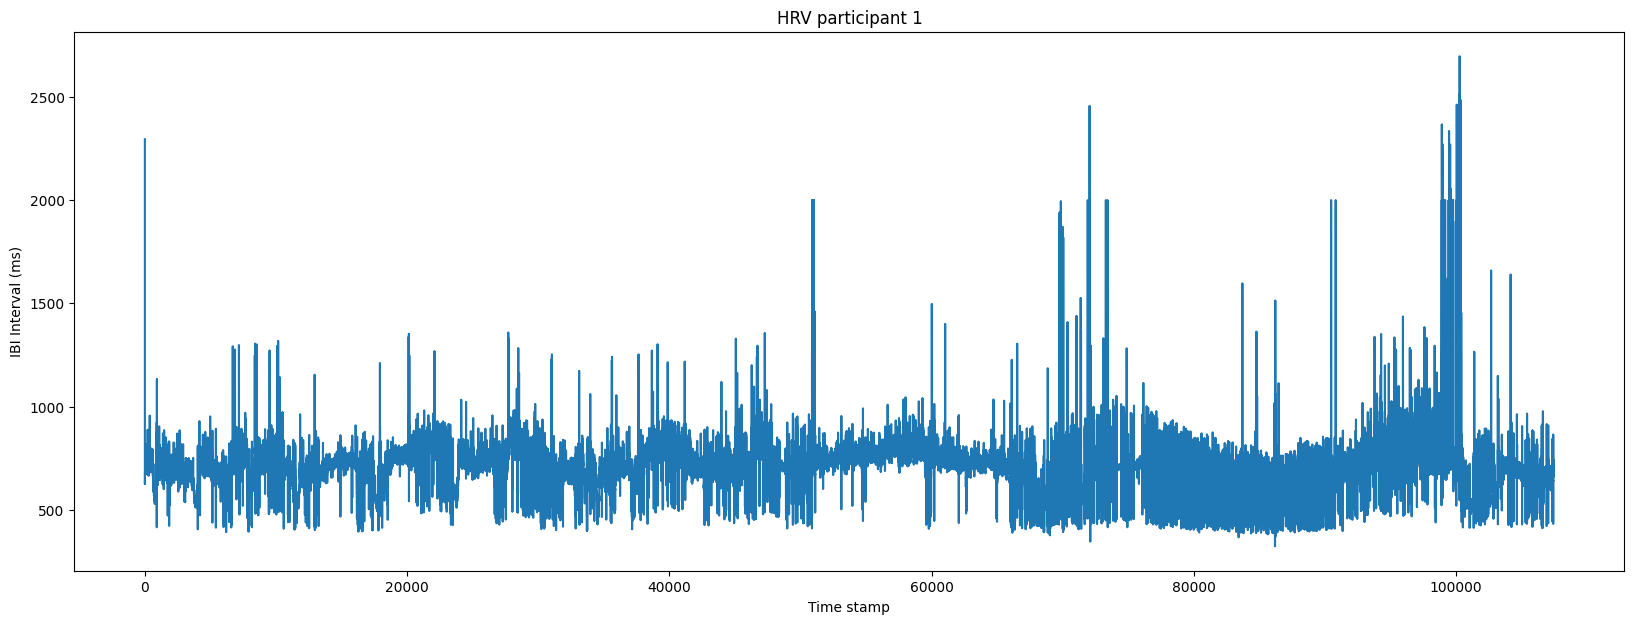

In [15]:
# Plot the HRV values and the timestamps.

plt.figure(figsize=(20, 7))
plt.title("HRV participant 1")
plt.xlabel("Time stamp")
plt.ylabel("IBI Interval (ms)")

plt.plot(HRV_1.HRV)
plt.show()

In [25]:
# Time domain analysis of Participant 1

IBI = HRV_1.HRV

def timedomain(IBI):
    results = {}

    hr = 60000/IBI
    
    results['Mean IBI (ms)'] = np.mean(IBI)
    results['STD IBI/SDNN (ms)'] = np.std(IBI)
    results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(IBI)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(IBI))))
    results['NNxx'] = np.sum(np.abs(np.diff(IBI)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(IBI)) > 50)*1) / len(IBI)
    return results



print("Time domain metrics - IBI-intervals:")
for k, v in timedomain(IBI).items():
    print("- %s: %.2f" % (k, v))


Time domain metrics - IBI-intervals:
- Mean IBI (ms): 707.65
- STD IBI/SDNN (ms): 139.83
- Mean HR (Kubios' style) (beats/min): 84.79
- Mean HR (beats/min): 86.93
- STD HR (beats/min): 12.52
- Min HR (beats/min): 22.24
- Max HR (beats/min): 185.62
- RMSSD (ms): 75.53
- NNxx: 6237.00
- pNNxx (%): 5.80


In [28]:
# Frequency domain analysis of Participant 1

# Fourier Transformation requires evenly sampled data, and the time between each timestamp in the dataset is currently
# not even. This can be done by interpolating the data.

# Creating an interpolation function.
x = np.cumsum(IBI)/1000000.0   # changed 1000 to 1000000 because there are more datapoints here than the guide.
f = interp1d(x, IBI, kind = "cubic")

# Sample rate for interpolation
fs = 4.0
steps = 1/fs

# Sampling from interpolation function
xx = np.arange(1, np.max(x), steps)
IBI_interpolated = f(xx)


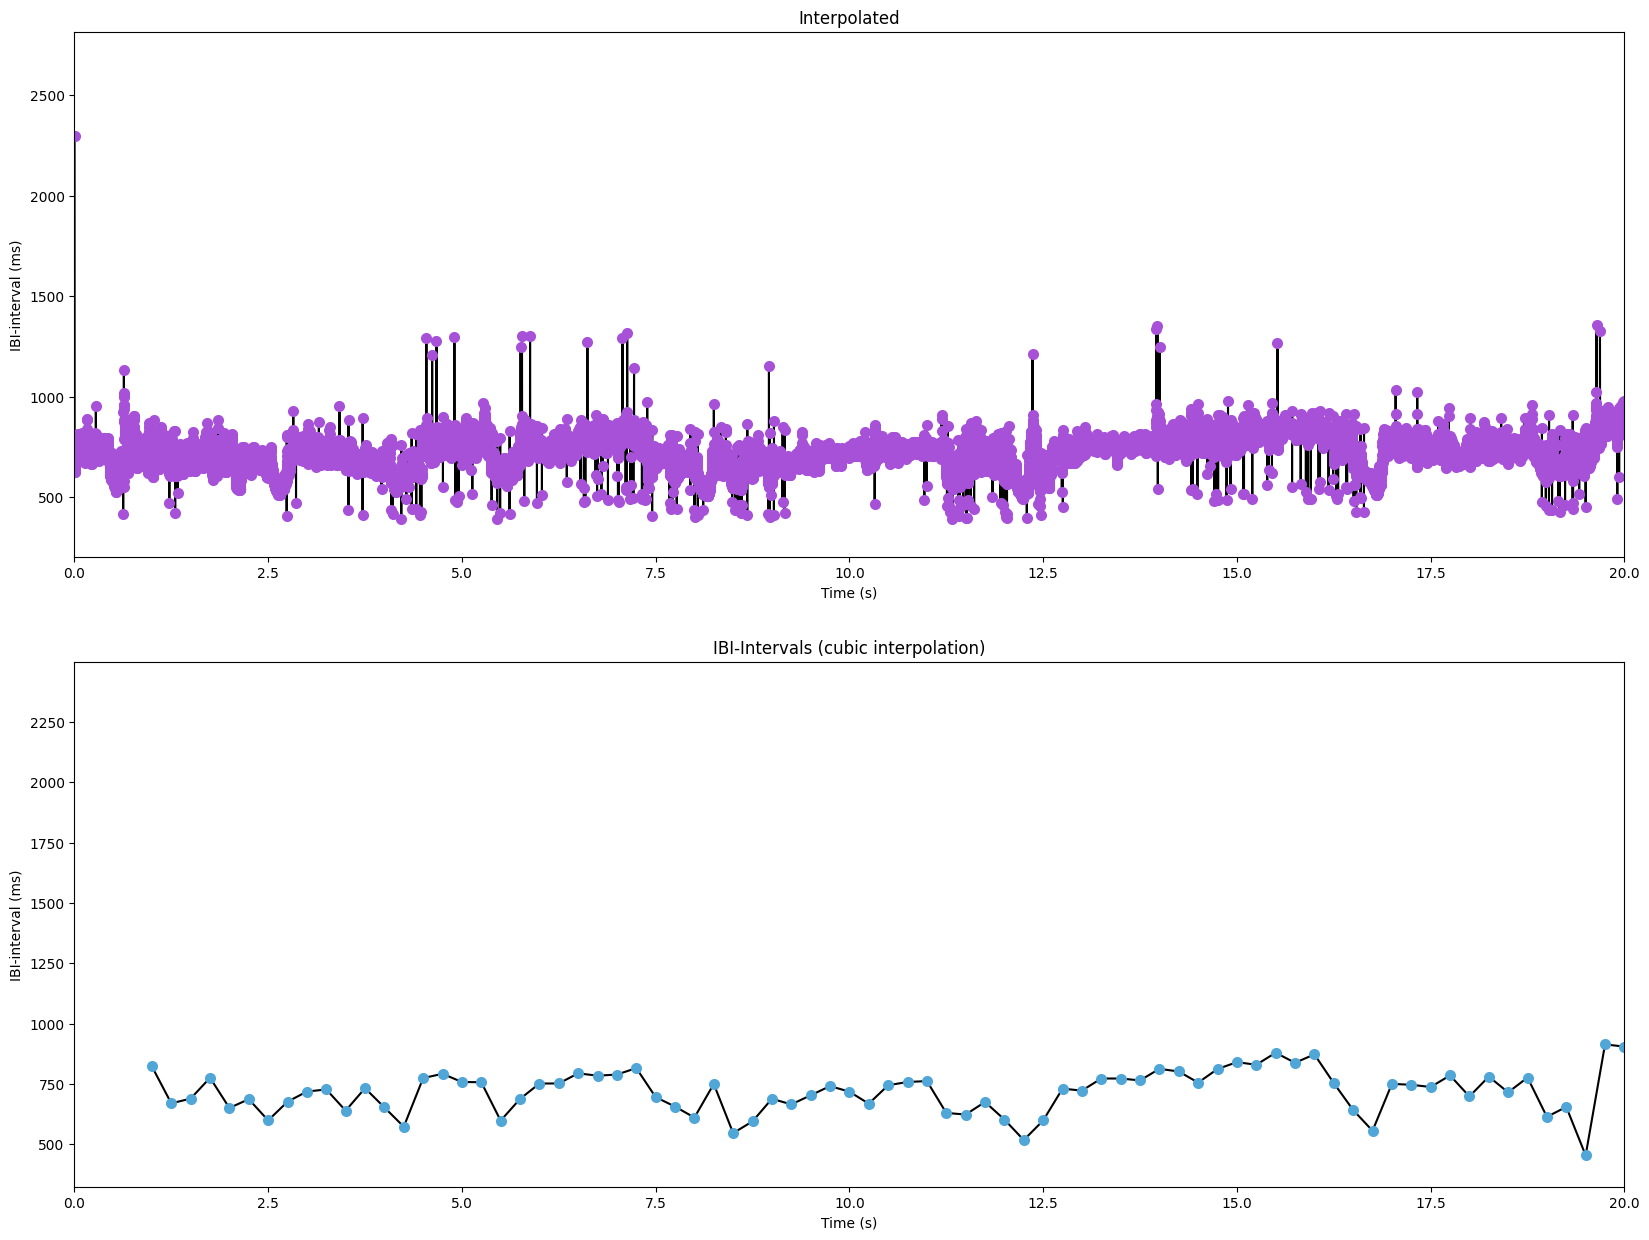

In [29]:
# Plot 
plt.figure(figsize=(20, 15))

plt.subplot(211)
plt.title("IBI intervals")
plt.plot(x, IBI, color="k", markerfacecolor="#A651D8", markeredgewidth=0, marker="o", markersize=8)
plt.xlabel("Time (s)")
plt.ylabel("IBI-interval (ms)")
plt.title("Interpolated")
plt.gca().set_xlim(0, 20)

plt.subplot(212)
plt.title("IBI-Intervals (cubic interpolation)")
plt.plot(xx, IBI_interpolated, color="k", markerfacecolor="#51A6D8", markeredgewidth=0, marker="o", markersize=8)
plt.gca().set_xlim(0, 20)
plt.xlabel("Time (s)")
plt.ylabel("IBI-interval (ms)")
plt.show()

OBS. These plots look a little different than the guide. 

In [30]:
def frequency_domain(rri, fs=4):
    # Estimate the spectral density using Welch's method
    fxx, pxx = signal.welch(x=IBI_interpolated, fs=fs)
    
    '''
    Segement found frequencies in the bands 
     - Very Low Frequency (VLF): 0-0.04Hz 
     - Low Frequency (LF): 0.04-0.15Hz 
     - High Frequency (HF): 0.15-0.4Hz
    '''
    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)

  # calculate power in each band by integrating the spectral density 
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])
    
    # sum these up to get total power
    total_power = vlf + lf + hf


     # find which frequency has the most power in each band
    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    # fraction of lf and hf
    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)
    
    results = {}
    results['Power VLF (ms2)'] = vlf
    results['Power LF (ms2)'] = lf
    results['Power HF (ms2)'] = hf   
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (lf/hf)
    results['Peak VLF (Hz)'] = peak_vlf
    results['Peak LF (Hz)'] = peak_lf
    results['Peak HF (Hz)'] = peak_hf

    results['Fraction LF (nu)'] = lf_nu
    results['Fraction HF (nu)'] = hf_nu
    return results, fxx, pxx


In [31]:
print("Frequency domain metrics:")
results, fxx, pxx = frequency_domain(IBI_interpolated)

for k, v in results.items():
    print("- %s: %.2f" % (k, v))

Frequency domain metrics:
- Power VLF (ms2): 1510.65
- Power LF (ms2): 1338.98
- Power HF (ms2): 2213.04
- Power Total (ms2): 5062.67
- LF/HF: 0.61
- Peak VLF (Hz): 0.02
- Peak LF (Hz): 0.05
- Peak HF (Hz): 0.39
- Fraction LF (nu): 37.70
- Fraction HF (nu): 62.30


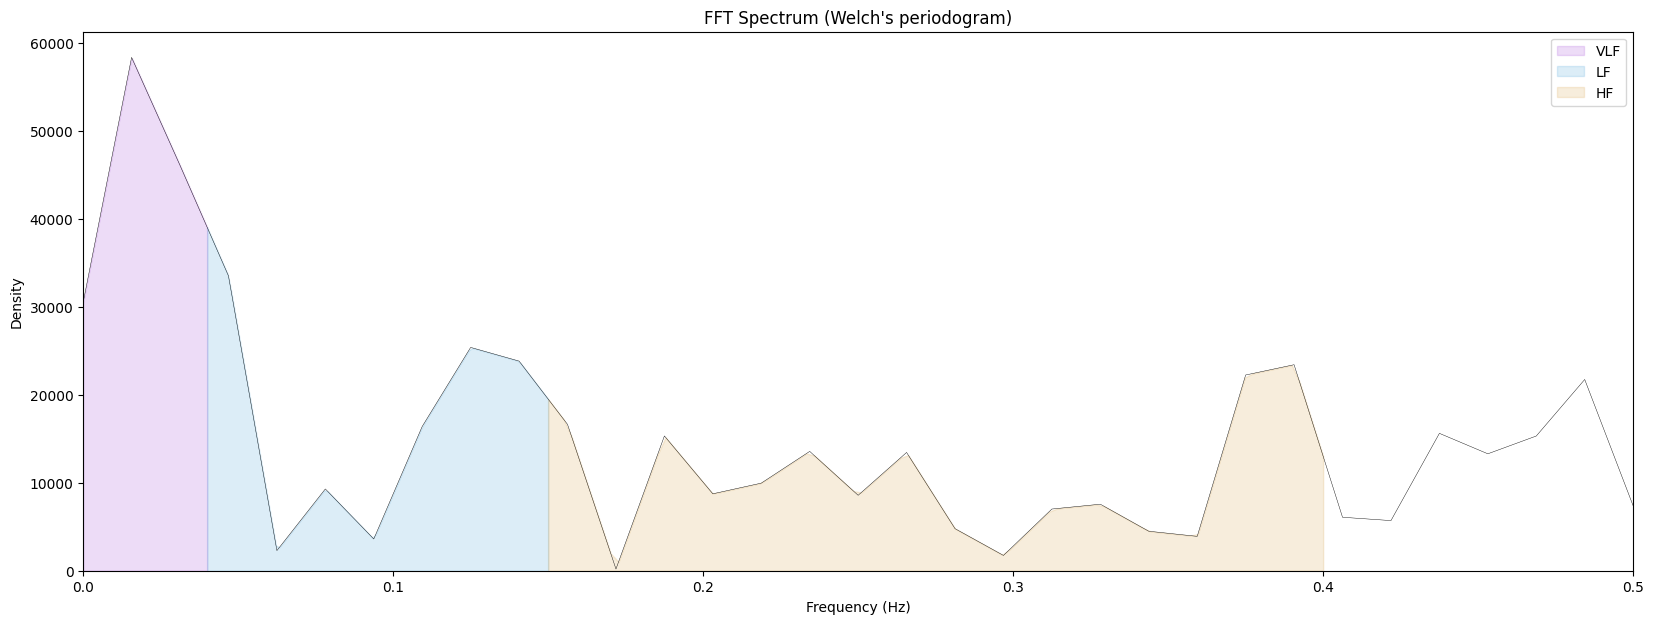

In [32]:
# Plot Welch periodogram

plt.figure(figsize=(20, 7))
plt.plot(fxx, pxx, color="k", linewidth=0.3)
plt.title("FFT Spectrum (Welch's periodogram)")

# create interpolation function for plotting frequency bands
psd_f = interp1d(fxx, pxx)

# setup frequency bands for plotting
x_vlf = np.linspace(0, 0.04, 100)
x_lf = np.linspace(0.04, 0.15, 100)
x_hf = np.linspace(0.15, 0.4, 100)

plt.gca().fill_between(x_vlf, psd_f(x_vlf), alpha=0.2, color="#A651D8", label="VLF")
plt.gca().fill_between(x_lf, psd_f(x_lf), alpha=0.2, color="#51A6D8", label="LF")
plt.gca().fill_between(x_hf, psd_f(x_hf), alpha=0.2, color="#D8A651", label="HF")

plt.gca().set_xlim(0, 0.5)
plt.gca().set_ylim(0)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Density")
plt.legend()
plt.show()

Non-linear Methods - THIS IS NOT WORKING. LOOK INTO IT AND FIND OUT WHY

SD1: 0.000 ms
SD2: 197.633 ms


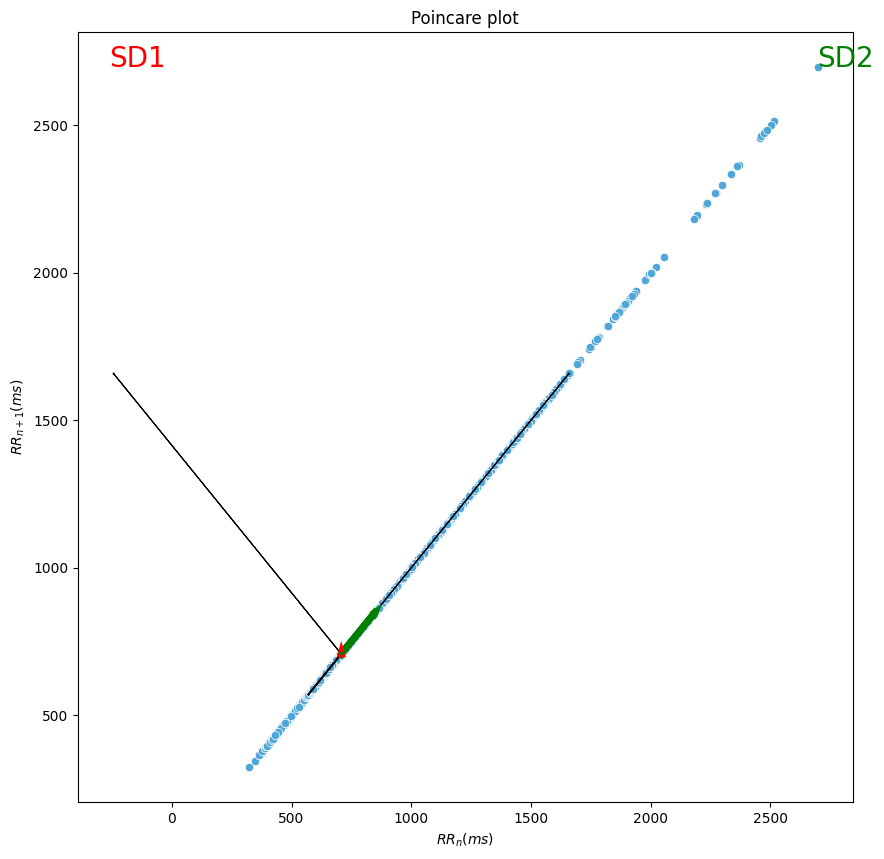

In [35]:
def plot_poincare(IBI):
    IBI_n = IBI[:-1]
    IBI_n1 = IBI[1:]

    sd1 = np.sqrt(0.5) * np.std(IBI_n1 - IBI_n)
    sd2 = np.sqrt(0.5) * np.std(IBI_n1 + IBI_n)

    m = np.mean(IBI)
    min_rr = np.min(IBI)
    max_rr = np.max(IBI)
    
    plt.figure(figsize=(10, 10))
    plt.title("Poincare plot")

    sns.scatterplot(x=IBI_n, y=IBI_n1, color="#51A6D8")

    plt.xlabel(r'$RR_n (ms)$')
    plt.ylabel(r'$RR_{n+1} (ms)$')

    e1 = Ellipse((m, m), 2*sd1, 2*sd2, angle=-45, linewidth=1.2, fill=False, color="k")
    plt.gca().add_patch(e1)

    plt.arrow(m, m, (max_rr-min_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)
    plt.arrow(m, m, (min_rr-max_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)

    plt.arrow(m, m, sd2 * np.sqrt(0.5), sd2 * np.sqrt(0.5), color="green", linewidth=5)
    plt.arrow(m, m, -sd1 * np.sqrt(0.5), sd1 * np.sqrt(0.5), color="red", linewidth=5)    
    plt.text(max_rr, max_rr, "SD2", fontsize=20, color="green")
    plt.text(m-(max_rr-min_rr)*0.4-20, max_rr, "SD1", fontsize=20, color="red")
    
    return sd1, sd2

sd1, sd2 = plot_poincare(IBI)
print("SD1: %.3f ms" % sd1)
print("SD2: %.3f ms" % sd2)